# Project 3: Web APIs & NLP

---
### Problem Statement
A resort wants to find out which subreddit the posts is coming from and how can we use a predictive model to see which subreddit a post came from?

---

### Table of Contents
---
- [Data Collection](#Data_Collection)
- [Data_Dictionary](#Data_Dictionary)
- [Exploratory Data Analysis and Cleaning](#EDA_and_Cleaning)
- [Preprocessing](#Preprocessing)
- [Modeling](#Modeling)
- [Prediction and Evaluation](#Prediction_and_Evaluation)
- [Conclusions and Recommendations](#Conclusion_and_Recommendations)
- [Sources](#Sources)

## Data_Collection

- Collected the data below, commented out because it is already saved in a csv. 

In [1]:
# import requests
# import pandas as pd
# import time 

# url = 'https://api.pushshift.io/reddit/search/submission'

# ski = pd.DataFrame()
# sb = pd.DataFrame()

# utc = 1615834010
# for i in range(10):
#     params = {
#     'subreddit': 'ski',
#     'size': 100,
#     'before': utc
#     }
#     res = requests.get(url, params)
#     data = res.json()
#     posts = data['data']
#     df_1 = pd.DataFrame(posts)
#     ski = pd.concat([ski, df_1])
#     utc = posts[-1]['created_utc']
#     time.sleep(3)

# utc = 1615492016
# for i in range(4):
#     params = {
#     'subreddit': 'snowboard',
#     'size': 100,
#     'before': utc
#     }
#     res = requests.get(url, params)
#     data = res.json()
#     posts = data['data']
#     df_1 = pd.DataFrame(posts)
#     sb = pd.concat([sb, df_1])
#     utc = posts[-1]['created_utc']
#     time.sleep(3)

# ski.to_csv(r'./data/ski.csv',index = False)
# sb.to_csv(r'./data/snowboard.csv',index = False)

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#NLP
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS 

In [3]:
ski = pd.read_csv('./data/ski.csv')
sb = pd.read_csv('./data/snowboard.csv')

In [4]:
ski.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media',
       'media_embed', 'media_only', 'no_follow', 'num_comments',
       'num_crossposts', 'over_18', 'parent_whitelist_status', 'permalink',
       'pinned', 'post_hint', 'preview', 'pwls', 'retrieved_on', 'score',
       'secure_media', 'secure_media_embed', 'selftext', 'send_replies',
       'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'subreddit_subscribers', 'subreddit_t

In [5]:
sb.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,crosspost_parent_list,steward_reports,removed_by,updated_utc,og_description,og_title,gilded,rte_mode,author_id,brand_safe
0,[],False,nsfw_celbs,NaN,[],NaN,text,t2_adibf428,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,VonFlush,NaN,[],NaN,text,t2_9r7fpp0h,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,AmbitiousJournalist3,NaN,[],NaN,text,t2_3rdwbj7n,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,_Riotz16,NaN,[],NaN,text,t2_6a0nqyzw,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,quicke43,NaN,[],NaN,text,t2_59nm98gn,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
sb_1 = pd.DataFrame(data = sb, columns = ['subreddit', 'id','author','selftext', 'title'])
ski_1 = pd.DataFrame(data = ski, columns = ['subreddit', 'id', 'author','selftext', 'title'])

# EDA_and_Cleaning

In [7]:
sb_1.drop_duplicates().shape

(399, 5)

In [8]:
ski_1.drop_duplicates().shape

(1000, 5)

In [9]:
# sb_1['selftext'].value_counts()

# ski_1['selftext'].value_counts()

# sb_1['title'].value_counts()

# ski_1['title'].value_counts()

In [10]:
df = pd.concat([sb_1, ski_1], ignore_index = True)
df

,subreddit,id,author,selftext,title
0,snowboard,m2rawn,nsfw_celbs,NaN,I got ya homie!
1,snowboard,m04x1t,VonFlush,NaN,Is this rideable?
2,snowboard,lsx39k,AmbitiousJournalist3,NaN,Does anyone know how to fix this?
3,snowboard,lrf8h0,_Riotz16,NaN,I’m super proud of this video I made and I wou...
4,snowboard,lrdi79,quicke43,I'm looking into getting new goggles cuz I can...,Any experience with the light sensitive scott ...
...,...,...,...,...,...
1394,ski,eya3vw,haxOn-,I am 14 and doing freestyle ski and I just ord...,Are Ruroc helmets good for freestyle skiing?
1395,ski,ey6f9d,Dropsu55,"Hi, do you know of any site that allows seeing...",Anyone knows a site to track historical open t...
1396,ski,ey5cm2,smashingwatermelon,"Hi guys,\n\nFinally decided to commit to a new...",Ski advice for a light weight skier
1397,ski,ey0xwl,xYuth,"So my skis are more park style, ive kinda grow...",Need some opinions!


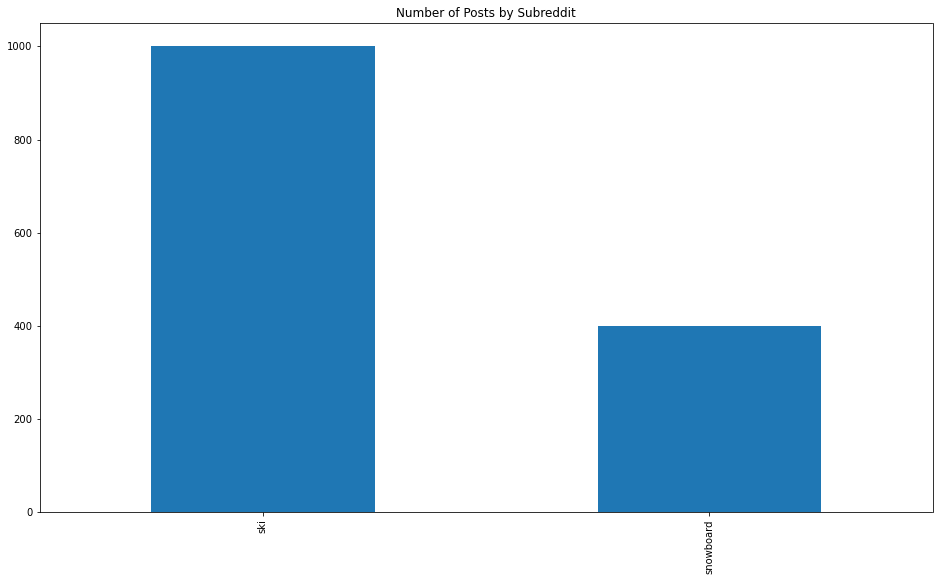

In [11]:
plt.figure(figsize = (16,9))
plt.title('Number of Posts by Subreddit')
df['subreddit'].value_counts().plot(kind = 'bar');
plt.savefig(r'./images/number_of_post.jpg')

Making the target variable into binary labels

In [12]:
df['subreddit'] = df['subreddit'].map({'snowboard': 0, 'ski': 1})

In [13]:
df.shape

(1399, 5)

In [14]:
# dropping duplicate if any
df.drop_duplicates(inplace = True)

In [15]:
## No Duplicates
df.shape

(1399, 5)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1399 entries, 0 to 1398
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1399 non-null   int64 
 1   id         1399 non-null   object
 2   author     1399 non-null   object
 3   selftext   706 non-null    object
 4   title      1399 non-null   object
dtypes: int64(1), object(4)
memory usage: 65.6+ KB


Filling all the null values with '' because all the null values are in the selftext column

In [17]:
df.fillna('', inplace = True)

Combining selftext and title together for the target variable

In [18]:
df['text'] = df['selftext'] + " " + df['title']

In [19]:
df['text']

0                                         I got ya homie!
1                                       Is this rideable?
2                       Does anyone know how to fix this?
3        I’m super proud of this video I made and I wo...
4       I'm looking into getting new goggles cuz I can...
                              ...                        
1394    I am 14 and doing freestyle ski and I just ord...
1395    Hi, do you know of any site that allows seeing...
1396    Hi guys,\n\nFinally decided to commit to a new...
1397    So my skis are more park style, ive kinda grow...
1398    Taking on account the snow quality (powder) an...
Name: text, Length: 1399, dtype: object

Lowering all the text

In [20]:
df['text'] = df['text'].str.lower()
df['text']

0                                         i got ya homie!
1                                       is this rideable?
2                       does anyone know how to fix this?
3        i’m super proud of this video i made and i wo...
4       i'm looking into getting new goggles cuz i can...
                              ...                        
1394    i am 14 and doing freestyle ski and i just ord...
1395    hi, do you know of any site that allows seeing...
1396    hi guys,\n\nfinally decided to commit to a new...
1397    so my skis are more park style, ive kinda grow...
1398    taking on account the snow quality (powder) an...
Name: text, Length: 1399, dtype: object

## Preprocessing
- Tokenizing 
- Lemmatization the text

Tokenizer:
- \w+: removes all the punctuation

In [21]:
df['text'].replace("i'm", 'i am')

0                                         i got ya homie!
1                                       is this rideable?
2                       does anyone know how to fix this?
3        i’m super proud of this video i made and i wo...
4       i'm looking into getting new goggles cuz i can...
                              ...                        
1394    i am 14 and doing freestyle ski and i just ord...
1395    hi, do you know of any site that allows seeing...
1396    hi guys,\n\nfinally decided to commit to a new...
1397    so my skis are more park style, ive kinda grow...
1398    taking on account the snow quality (powder) an...
Name: text, Length: 1399, dtype: object

In [22]:
tokenizer = RegexpTokenizer(r'[a-z]\w+')
lemmatizer = WordNetLemmatizer()
list_token = []
for text in df['text']:
    # tokenize it 
    result = []
    results = tokenizer.tokenize(text)
    for word in results:
        # lemmatize it 
        words = lemmatizer.lemmatize(word)
        result.append(words)
    list_token.append(result)


In [23]:
list_token[:2]

[['got', 'ya', 'homie'], ['is', 'this', 'rideable']]

Making list of list in list of string

In [24]:
lst = []
for i in list_token:
    listToStr = ' '.join([str(elem) for elem in i]) 
    lst.append(listToStr)
lst[:2]

['got ya homie', 'is this rideable']

In [25]:
# # tokenizer = RegexpTokenizer('[a-z]+')
# tokenizer = RegexpTokenizer('\w+')
# print(tokenizer.tokenize(df['text'][1396]))

Word Cloud for Subreddit

In [26]:
stop_words_1 = set(CountVectorizer(stop_words = 'english').get_stop_words())
## from world Cloud
stop_words_wc = set(STOPWORDS)
all_stopwords = stop_words_1.union(stop_words_wc)

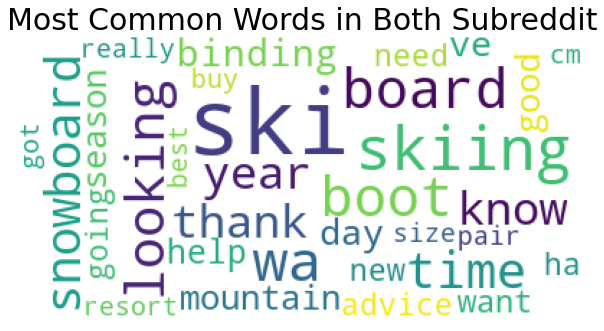

In [29]:
word = ''
for i in lst: 
      
    # typecaste each val to string 
    i = str(i) 
  
    # split the value 
    tokenst = i.split() 
      
    # Converts each token into lowercase 
    
    for words in tokenst: 
        word = word + words + ' '
  
  
wordcloudt = WordCloud(
                background_color ='white', 
                stopwords = all_stopwords, 
                min_font_size = 10).generate(word) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloudt) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Most Common Words in Both Subreddit", fontsize=30)
plt.savefig('./images/wordcloud.jpg');
  
plt.show()

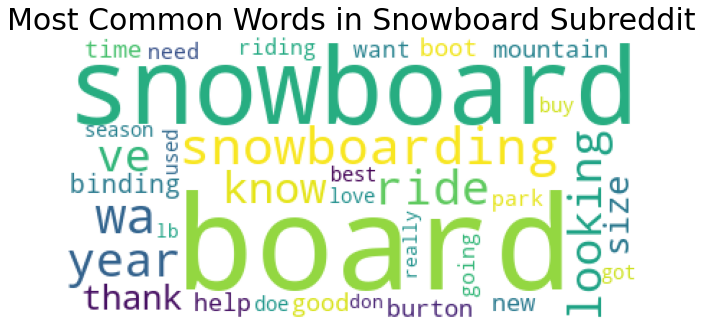

In [30]:
word = ''
for i in lst[:399]: 
      
    # turning the list into string 
    i = str(i) 
  
    # split the value 
    tokenst = i.split() 
      
    # Converts each token into lowercase 
    
    for words in tokenst: 
        word = word + words + ' '
  
  
wordcloudt = WordCloud( 
                background_color ='white', 
                stopwords = all_stopwords, 
                min_font_size = 10).generate(word) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloudt) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Most Common Words in Snowboard Subreddit", fontsize=30)
plt.savefig('./images/snowboard_cloud.jpg');
  
plt.show()

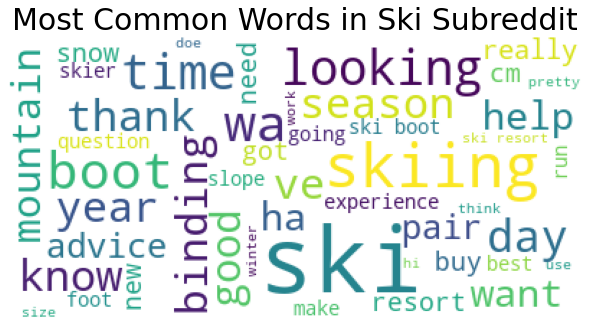

In [31]:
word = ''
for i in lst[400:]: 
      
    # typecaste each val to string 
    i = str(i) 
  
    # split the value 
    tokenst = i.split() 
      
    # Converts each token into lowercase 
    
    for words in tokenst: 
        word = word + words + ' '
  
  
wordcloudt = WordCloud( 
                background_color ='white', 
                stopwords = all_stopwords, 
                min_font_size = 10).generate(word) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloudt) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Most Common Words in Ski Subreddit", fontsize=30)
plt.savefig('./images/ski_cloud.jpg');
  
plt.show()

In [30]:
df['final_text'] = lst
df

,subreddit,id,author,selftext,title,text,final_text
0,0,m2rawn,nsfw_celbs,,I got ya homie!,i got ya homie!,got ya homie
1,0,m04x1t,VonFlush,,Is this rideable?,is this rideable?,is this rideable
2,0,lsx39k,AmbitiousJournalist3,,Does anyone know how to fix this?,does anyone know how to fix this?,doe anyone know how to fix this
3,0,lrf8h0,_Riotz16,,I’m super proud of this video I made and I wou...,i’m super proud of this video i made and i wo...,super proud of this video made and would love ...
4,0,lrdi79,quicke43,I'm looking into getting new goggles cuz I can...,Any experience with the light sensitive scott ...,i'm looking into getting new goggles cuz i can...,looking into getting new goggles cuz can see s...
...,...,...,...,...,...,...,...
1394,1,eya3vw,haxOn-,I am 14 and doing freestyle ski and I just ord...,Are Ruroc helmets good for freestyle skiing?,i am 14 and doing freestyle ski and i just ord...,am and doing freestyle ski and just ordered he...
1395,1,ey6f9d,Dropsu55,"Hi, do you know of any site that allows seeing...",Anyone knows a site to track historical open t...,"hi, do you know of any site that allows seeing...",hi do you know of any site that allows seeing ...
1396,1,ey5cm2,smashingwatermelon,"Hi guys,\n\nFinally decided to commit to a new...",Ski advice for a light weight skier,"hi guys,\n\nfinally decided to commit to a new...",hi guy finally decided to commit to new pair o...
1397,1,ey0xwl,xYuth,"So my skis are more park style, ive kinda grow...",Need some opinions!,"so my skis are more park style, ive kinda grow...",so my ski are more park style ive kinda grown ...


In [31]:
df.subreddit.value_counts(normalize = True)

1    0.714796
0    0.285204
Name: subreddit, dtype: float64

In [32]:
df.to_csv(r'./data/final_data.csv',index = False)

In [33]:
# Let's look at sklearn's stopwords.
stop = CountVectorizer(stop_words = 'english').get_stop_words()
# stop

#### Difference between regular text and tokenize text

In [34]:
lst = [item for item in df['text'] if item not in stop]
df['text'] = lst
print(df['text'][1396])
print('--------------------------------------------------------')
print(df['final_text'][1396])

hi guys,

finally decided to commit to a new pair of skis. have been thinking rossignol experience 84 as i have skied on multiple occasions. i'm 178cm,  weight only 65kg, more of an intermediate skier (depends on how you defines it...) and mainly ski in australia, so mostly on front side, firm to slightly soft snow. the shop that i rent from only have 163cm and that's what i've been ski on, very versatile, fun at short crave turns but does not go very fast and chatter at high speed. perhaps it's too short? the guy at the shop suggested that the length appropriate for me given my weight. i'm a decent ice skater and thus very comfortable putting weight on edges despite being "intermediate" skier.

the other one that i've tried recently was dynastar speedzone 4x4 82 at 171cm, i found that very stable at wider turns and at speed, kind of like that feeling, but i cannot do short turns on this thing gracefully. i'm guessing i cannot put enough force on the edge unless i'm going fast. either 

In [35]:
X = df['final_text']
y = df['subreddit']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

## Modeling

### Logistic Regression with CountVectorizer

In [37]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),   #count vectorizor
    ('lr', LogisticRegression())     #model 
])

In [38]:
params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__max_features': [50, 100, 500, 1000, 1500],      #iterate over these options to see what is best
    'cvec__min_df': [2,3,5],
    'cvec__max_df': [.75, .8, .9, .95]
   
}
gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X_train, y_train)
print(f'gs.best.score_: {gs.best_score_}') 
print(f'gs.best.params_: {gs.best_params_}')
gs.best_estimator_

gs.best.score_: 0.8617710465274935
gs.best.params_: {'cvec__max_df': 0.75, 'cvec__max_features': 1500, 'cvec__min_df': 2, 'cvec__stop_words': 'english'}


Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.75, max_features=1500, min_df=2,
                                 stop_words='english')),
                ('lr', LogisticRegression())])

In [39]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9542421353670162, 0.88)

In [40]:
## Trying out with new params
params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__max_features': [300, 700 , 500],      
    'cvec__min_df': [0,1,2],
    'cvec__max_df': [.4, .5,.65,.75],
}

gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X_train, y_train) 

print(f'best score: {gs.best_score_}')
print(f'best params: {gs.best_params_}')
gs.best_estimator_

best score: 0.8598662846227317
best params: {'cvec__max_df': 0.4, 'cvec__max_features': 700, 'cvec__min_df': 2, 'cvec__stop_words': 'english'}


Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.4, max_features=700, min_df=2,
                                 stop_words='english')),
                ('lr', LogisticRegression())])

In [41]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9351763584366063, 0.8828571428571429)

### Random Forest

In [42]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier()

In [43]:
pipe1 = Pipeline([
    ('tfidf', TfidfVectorizer()),   #Tfidf vectorizor  
    ('rf', RandomForestClassifier(random_state=42))        #model 
])

The cell below takes a long time to run

In [44]:
params1 = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [50, 100, 500, 1000, 1500],      
    'tfidf__min_df': [2, 3, 5],
    'tfidf__max_df': [.75, .8, .9, .95],
    'rf__n_estimators': [10, 50, 100],  
    'rf__max_depth': [None, 3, 5],

   }   
gs1 = GridSearchCV(pipe1, param_grid=params1, cv=5)
gs1.fit(X_train, y_train) 
print(f'gs1.best.score_: {gs1.best_score_}') 
print(f'gs1.best.params_: {gs1.best_params_}')
gs1.best_estimator_

gs1.best.score_: 0.8789200273410799
gs1.best.params_: {'rf__max_depth': None, 'rf__n_estimators': 100, 'tfidf__max_df': 0.75, 'tfidf__max_features': 1000, 'tfidf__min_df': 3, 'tfidf__stop_words': 'english'}


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, max_features=1000, min_df=3,
                                 stop_words='english')),
                ('rf', RandomForestClassifier(random_state=42))])

In [45]:
print(f'Train Score GS1A: {gs1.score(X_train,y_train)}')
print(f'Test Score GS1A: {gs1.score(X_test,y_test)}')

Train Score GS1A: 0.9866539561487131
Test Score GS1A: 0.8828571428571429


In [46]:
# tyring it out with new params
params1 = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [750, 875,1000,1250],      
    'tfidf__min_df': [2, 3, 5],
    'tfidf__max_df': [0.5, 0.65, 0.7, .75],
    'rf__n_estimators': [100], 
    'rf__max_depth': [None]
   }   
gs1 = GridSearchCV(pipe1, param_grid=params1, cv=5)
gs1.fit(X_train, y_train)
print(f'gs1.best.score_: {gs1.best_score_}') 
print(f'gs1.best.params_: {gs1.best_params_}')
gs1.best_estimator_

gs1.best.score_: 0.8789200273410799
gs1.best.params_: {'rf__max_depth': None, 'rf__n_estimators': 100, 'tfidf__max_df': 0.5, 'tfidf__max_features': 1000, 'tfidf__min_df': 3, 'tfidf__stop_words': 'english'}


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3,
                                 stop_words='english')),
                ('rf', RandomForestClassifier(random_state=42))])

In [47]:
gs1.score(X_train,y_train), gs1.score(X_test, y_test)

(0.9866539561487131, 0.8828571428571429)

### Prediction_and_Evaluation

In [48]:
#generate predictions on the test data
predictions = gs.predict(X_test)
#get the true negative, false positive, false negative, and true positive 
#value from the confusion_matrix.
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
misclassification = 1 - accuracy
print(f'Accuracy rate: {accuracy}, misclassification rate: {misclassification}')

Accuracy rate: 0.8828571428571429, misclassification rate: 0.1171428571428571


In [49]:
#generate predictions on the test data
predictions = gs1.predict(X_test)
#get the true negative, false positive, false negative, and true positive 
#value from the confusion_matrix.
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
misclassification = 1 - accuracy
print(f'Accuracy rate: {accuracy}, misclassification rate: {misclassification}')

Accuracy rate: 0.8828571428571429, misclassification rate: 0.1171428571428571


In [50]:
#Display the confusion matrix table
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(data=cm, columns=['predicted r/snowboard', 
                                       'predicted r/ski'], 
                     index=['Actual r/snowboard', 'Actual r/ski'])
cm_df

,predicted r/snowboard,predicted r/ski
Actual r/snowboard,68,32
Actual r/ski,9,241


In [51]:
# Get predictions
pred = gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

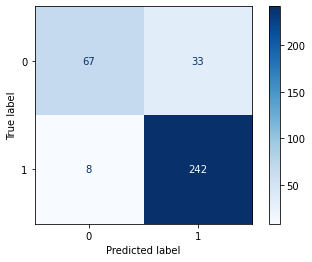

In [52]:
# View confusion matrix
plot_confusion_matrix(gs, X_test, y_test,  cmap='Blues', values_format='d');
plt.savefig(r'./images/confusion_matrix.png')

In [53]:
specificity = tn/(tn+fp)
specificity

0.67

In [54]:
lr_1 = gs.best_estimator_.steps[1][1]
feature_names = gs.best_estimator_.steps[0][1].get_feature_names()

In [55]:
lr_coefs = lr_1.coef_[0]

getting the coefficient from the logistic regression model 

In [56]:
#Put the coeffs and the features in a dataframe
log_reg_coef_df = pd.DataFrame({'word_features':feature_names,
                              'coefs':lr_coefs})
log_reg_coef_df  = log_reg_coef_df .sort_values('coefs')

In [57]:
log_reg_coef_df.tail(10)

,word_features,coefs
334,lift,0.808459
267,home,0.833429
401,oakley,0.916786
238,hackerone,1.038563
420,pas,1.078058
588,switzerland,1.088925
544,skier,1.288027
685,workout,1.473310
545,skiing,1.631889
542,ski,1.892496


In [58]:
log_reg_coef_df.head(10)

,word_features,coefs
556,snowboarding,-2.504086
554,snowboard,-2.423516
66,board,-2.140462
555,snowboarder,-1.666493
75,burton,-1.639700
298,japan,-1.558597
78,buyer,-1.407644
235,guide,-1.208925
218,goggles,-1.009575
92,check,-0.991943


In [59]:
coef_df = pd.DataFrame([lr_coefs, feature_names], index = ['Coefficients', 'Features']).T
coef_df = coef_df.set_index('Features')
coef_df = coef_df.sort_values(by='Coefficients',ascending=False)
coef_df.head(10)

,Coefficients
Features,
ski,1.8925
skiing,1.63189
workout,1.47331
skier,1.28803
switzerland,1.08893
pas,1.07806
hackerone,1.03856
oakley,0.916786
home,0.833429


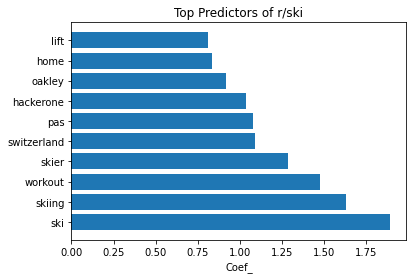

In [60]:
plt.barh(y=coef_df.index[:10], width=coef_df['Coefficients'][:10]);
plt.title('Top Predictors of r/ski')
plt.xlabel('Coef_');
plt.savefig(r'./images/r_ski_predictor.png', bbox_inches = "tight")

In [61]:
coef_df.shape

(700, 1)

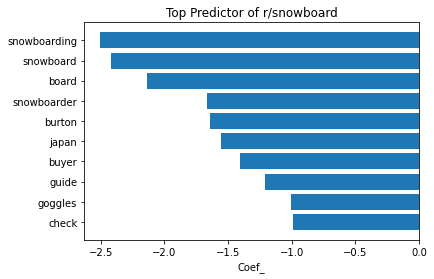

In [64]:
plt.barh(y=coef_df.index[690:], width=coef_df['Coefficients'][690:]);
plt.title('Top Predictor of r/snowboard')
plt.xlabel('Coef_');
plt.savefig(r'./images/r_snowboard_predictor.png', bbox_inches = "tight")

## Conclusion_and_Recommendations

* Both model were successful, they both beat the baseline by more than 20% 
* Logistic Regression was the better model and its coefficient makes the data more understandable
* The Next Steps would be gather new data and implement into my model to see the score

### Sources
---
https://api.pushshift.io/reddit/search/submission